# Description

This notebook generates all the figures and tables of the paper:
[Optimal execution strategy with an uncertain volume target [Vaes & Hauser (2018)]](https://arxiv.org/abs/1810.11454).

# Packages & funtions

## General packages

In [1]:
# adds the maximum number of processors as possible to do parallel computing
using Distributed
if nworkers() < 3
#     addprocs() # uncomment to have parallel computing
end;

In [2]:
##########################
### Importing packages ###
##########################

# basic packages
@everywhere using Base
@everywhere using NaNMath
@everywhere using LinearAlgebra

# plots
@everywhere using Plots
@everywhere using StatsPlots

# stats
@everywhere using StatsBase
@everywhere using Distributions
@everywhere using Colors
@everywhere using Measures

# optimisation packages
@everywhere using JuMP
@everywhere using Gurobi
@everywhere using Optim

# files management packages
@everywhere using JLD
@everywhere using JLD2
@everywhere using Images, FileIO
@everywhere using DataFrames
@everywhere using Markdown
@everywhere using LaTeXStrings

# time
@everywhere using TimerOutputs

import Base: hash, rand

pyplot();

┌ Warning: Error requiring `HDF5` from `Plots`
│   exception = (LoadError("/Users/jvaes/.julia/packages/Plots/uCh2y/src/backends/hdf5.jl", 162, UndefVarError(:HDF5Group)), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x00000001012ebab2, Ptr{Nothing} @0x00000001012caaca, Ptr{Nothing} @0x00000001012caaa0, Ptr{Nothing} @0x00000001012a1a10, Ptr{Nothing} @0x00000001014749a4, Ptr{Nothing} @0x0000000101475c7c, Ptr{Nothing} @0x00000001014743d0, Ptr{Nothing} @0x00000001014746fa, Base.InterpreterIP(CodeInfo(
    @ /Users/jvaes/.julia/packages/Plots/uCh2y/src/backends/hdf5.jl:162 within `top-level scope'
1 ─      $(Expr(:thunk, CodeInfo(
    @ none within `top-level scope'
1 ─     return $(Expr(:method, :_write_datatype_attr))
)))
│        $(Expr(:method, :_write_datatype_attr))
│   %3 = Core.TypeVar(:T)
│   %4 = Core.Typeof(_write_datatype_attr)
│   %5 = Core.apply_type(Union, HDF5Group, HDF5Dataset)
│   %6 = Core.apply_type(Type, %3)
│   %7 = Core.svec(%4, %5, %6)
│   %8 = Core.svec(%3

## Personal packages

In [3]:
###################################
### Importing personal packages ###
###################################

@everywhere thePathToImplementationFolder = "src/"

@everywhere include("$thePathToImplementationFolder/personnal_math_functions.jl")
using .PersonnalMathFunctionsModule

@everywhere include("$thePathToImplementationFolder/strategy.jl")
using .StrategyModule

@everywhere include("$thePathToImplementationFolder/simulation_pararmeters.jl")
using .SimulationParametersModule

@everywhere include("$thePathToImplementationFolder/uncertainty_structure.jl")
using .UncertaintyStructureModule

@everywhere include("$thePathToImplementationFolder/market_details.jl")
using .MarketDetailsModule

@everywhere include("$thePathToImplementationFolder/trader.jl")
using .TraderModule

@everywhere include("$thePathToImplementationFolder/help_files.jl")
using .HelpFilesModule

@everywhere include("$thePathToImplementationFolder/ne_help_functions.jl")
using .NEHelpFunctionsModule

@everywhere include("$thePathToImplementationFolder/mean_variance.jl")
using .MeanVarianceModule

@everywhere include("$thePathToImplementationFolder/trading_cost.jl")
using .TradingCostModule

@everywhere include("$thePathToImplementationFolder/mean_cvar.jl")
using .MeanCVaRModule

@everywhere include("$thePathToImplementationFolder/optimal_strategy.jl")
using .OptimalStrategyModule

@everywhere include("$thePathToImplementationFolder/performance.jl")
using .PerformanceModule

@everywhere include("$thePathToImplementationFolder/plots_optimal_strategy.jl")
using .PlotOptimalStrategyModule

Academic license - for non-commercial use only
Academic license - for non-commercial use only


## Notebook related functions
Imports functions that are used in this notebook to present the results.

In [4]:
# imports the functions needed in the script to compute, plot, and evaluate the performance of the optimal strategies
include("$thePathToImplementationFolder/script_functions.jl");

# Parameters

## Parameters related to the notebook

In [5]:
##########################################################
### Begin: Parameters uniquely related to the notebook ###
##########################################################

# tells if one desires to delete all outputs of the sources code and keep only the ones from the script
theKeepOnlyNotebookOutputs = true

# tells if one desires to show the source LaTeX code of the tables generated
theGenerateLatexTables = false

# tells if one desires to have print the name of the files where the plots and realisations are saved.
theGiveInfoOnOutputFiles = true

# the folder to save the images generated by the notebook
theFolderImages = "outputs/images/"

########################################################
### End: Parameters uniquely related to the notebook ###
########################################################

"outputs/images/"

## Parameters related to the algorithm to use (common for all simulations)

In [6]:
####################################################
### Begin: Common parameters for all simulations ###
####################################################

# should all the strategies be computed even if one has already a file with the solution?
theRecomputeOptimalStrategies = false

# should the realisations and performance of the strategies be computed even if one has already a file with them?
theRecomputePerformances = false

##############################
### Optimisation variables ###
##############################

theOptimiseTradingPlan          = true
theOptimiseRedistributionMatrix = false

################
### Recourse ###
################

theConsiderRecourse = false

#####################
### Methods names ###
#####################

theMeanVarianceModel = "Mean-Variance"
theMeanCVaRModel     = "Mean-CVaR_Optim"

# algorithm to use in the Optim package
theAlgorithm = "LBFGS"

# maximum number of iterations allowed to find the optimal solution
theMaximumNumberOfIterations = 300;

# uncertainty method: how the price shifts and volume forecasts are distributed
theUncertaintyGenerationMethod = "normal"

###################
# CVaR parameters #
###################

# parameters to estimate the CVaR with Monte-Carlo
theNSamples                  = 5 * 10^6 # number of samples generated to estimate the CVaR of the trading cost
theNSamplesPerIteration      = 10^4    # number of samples generated per iterate (for computational reasons)

# tells whether the optimisation is first done use a low number of samples to estimate CVaR and then augmented until to reach the desired precision
theAdaptiveNumberOfSamples = true

############################################
# Parameters for the logs of the functions #
############################################

# tells which functions are allowed to print messages
theFunctionsShowPrintLogs = Dict(
    "get_optimal_strategy_mean_variance" => true,
    "get_optimal_strategy_mean_CVaR_Optim" => true,
    "get_optimal_strategy_mean_CVaR_Optim_adaptative_number_of_samples" => true,
    "get_optimal_strategy_mean_CVaR_Gurobi" => true,
    "get_optimal_strategy_mean_CVaR_adaptative_number_of_samples" => true,
    );

# tells which functions should not show the @info messages
theFunctionsNotShowInfoLogs = Dict(
    "get_optimal_strategy_mean_CVaR" => true,
    "get_optimal_strategy_mean_variance" => true
    );

#########################
# Simulation parameters #
#########################

theSimulationParameters = SimulationParametersModule.get_simulation_parameters(
    aMethod                       = theMeanVarianceModel,
    aUncertaintyGenerationMethod  = theUncertaintyGenerationMethod,
    aOptimiseTradingPlan          = theOptimiseTradingPlan,
    aOptimiseRedistributionMatrix = theOptimiseRedistributionMatrix,
    aAlgorithm                    = theAlgorithm,
    aParametersCVaROptimisation   = Dict(
                                        "NSamples"                  => theNSamples,
                                        "NSamplesPerIteration"      => theNSamplesPerIteration,
                                        "MaximumNumberOfIterations" => theMaximumNumberOfIterations,
                                        "AdaptiveNumberOfSamples"   => theAdaptiveNumberOfSamples
                                        ),
    aConsiderRecourse             = theConsiderRecourse,
    aRecomputeOptimalStrategies   = theRecomputeOptimalStrategies,
    aRecomputePerformances        = theRecomputePerformances,
    aFunctionsShowPrintLogs       = theFunctionsShowPrintLogs,
    aFunctionsNotShowInfoLogs     = theFunctionsNotShowInfoLogs
    );

##################################################
### End: Common parameters for all simulations ###
##################################################

## Uncertainty structure

In [7]:
################################ 
# Begin: uncertainty structure #
################################

# the time where the trading must end [0,T]
theT = 5

# number of trading periods
theNTradingPeriods = 5

# length of the trading periods
theTaus = ones(theNTradingPeriods) * theT/theNTradingPeriods

##############################
# Price shifts distributions #
##############################

# the price shifts distributions if they are the same for all trading periods
theσ = 0.95 # the asset volatility
theSamePricesDistributions     = Array{Any}(undef,theNTradingPeriods)
[theSamePricesDistributions[i] = Distributions.Normal(0.0, theσ * sqrt(theTaus[i])) for i=1:theNTradingPeriods]

# the price shifts distributions if they differ from one trading periods to the other
theDifferentPricesDistributions     = Array{Any}(undef,theNTradingPeriods)
[theDifferentPricesDistributions[i] = Distributions.Normal(0.0, theσ * sqrt(theTaus[i])) for i=1:theNTradingPeriods] # to modify as wished
    
##################################
# Forecast updates distributions #
##################################

# the initial volume target
theD0 = 5 * 10.0^5

# For some simulations, we assume that the forecast update distribution varies from one trading period to the other.
# For any model, we assume the last period is free of a forecast update as the demand is perfectly known at the start of the last trading period.

## if the forecast update distribution is the same for all trading periods
thePercentageD0VolumeUncertainty  = 0.1
theSameForecastDistributions      = Array{Any}(undef,theNTradingPeriods)
[theSameForecastDistributions[i]  = Distributions.Normal(0.0, thePercentageD0VolumeUncertainty * theD0 *  sqrt(theTaus[i])) for i=1:theNTradingPeriods]
theSameForecastDistributions[end] = Distributions.Normal(0.0,10.0^-15)                             

## if the forecast update distribution differs from one trading periods to the other
theLocalForecastUpdateDistributionsStds = theD0.*[1, 3, 5, 2].*(10.0^-2)
theLocalForecastUpdateDistributionsStds = theD0.*rand(theNTradingPeriods-1).*(10.0^-2)
theDifferentForecastDistributions = Array{Any}(undef,theNTradingPeriods)
if length(theLocalForecastUpdateDistributionsStds) != theNTradingPeriods-1
    @error(string("The number of forecast standard deviations should be equal to ", theNTradingPeriods-1))
end
[theDifferentForecastDistributions[i]  = Distributions.Normal(0.0,theLocalForecastUpdateDistributionsStds[i]) for i=1:theNTradingPeriods-1]
theDifferentForecastDistributions[end] = Distributions.Normal(0.0,10.0^-15);

############################## 
# End: Uncertainty structure #
##############################

## Market details

In [8]:
######################### 
# Begin: Market details #
#########################

# details on the market volume and price
theDailyVolume = 5 * 10^6 # the daily volume traded
theS0          = 50.0     # the initial price

##########################################################
### Temporary and permanent impact function parameters ###
##########################################################

# parameter b (bid-ask spread)

## in case of uniform parameters over all trading periods
theLocalSameBidAskSpreads      = 0.0025 * theS0 # the bid-ask spread over all trading periods
theSameBidAskSpreads          = fill(theLocalSameBidAskSpreads, theNTradingPeriods)

## in case of different parameters over all trading periods
theLocalDifferentBidAskSpreads = [0.003,  0.0025, 0.0025,  0.004,  0.005] * theS0
theDifferentBidAskSpreads     = Array{Float64,1}(undef, theNTradingPeriods)
[theDifferentBidAskSpreads[i] = theLocalDifferentBidAskSpreads[i] for i = 1:theNTradingPeriods]

# parameter ϵ (epsilon)

## in case of uniform parameters over all trading periods
theLocalSameEpsilons      = theLocalSameBidAskSpreads/2 # the value of epsilon if it is the same over all trading periods
theSameEpsilons          = fill(theLocalSameEpsilons, theNTradingPeriods)

## in case of different parameters over all trading periods
theLocalDifferentEpsilons = theLocalDifferentBidAskSpreads./2 # the value of epsilon for each trading period
theDifferentEpsilons     = Array{Float64,1}(undef, theNTradingPeriods)
[theDifferentEpsilons[i] = theLocalDifferentEpsilons[i] for i = 1:theNTradingPeriods]

# parameter η (eta)

## in case of uniform parameters over all trading periods
theLocalSameEtas      = theLocalSameBidAskSpreads/(0.01*theDailyVolume) # the value of eta if it is the same over all trading periods
theSameEtas          = fill(theLocalSameEtas, theNTradingPeriods)

## in case of different parameters over all trading periods
theLocalDifferentEtas = theLocalDifferentBidAskSpreads./(0.01*theDailyVolume) # the value of eta for each trading period
theDifferentEtas     = Array{Float64,1}(undef, theNTradingPeriods)
[theDifferentEtas[i] = theLocalDifferentEtas[i] for i = 1:theNTradingPeriods]

# parameter γ (gammas)

theCoeffGammas     = 5
theSameGammas      = theCoeffGammas.*theSameBidAskSpreads./(0.1*theDailyVolume)
theDifferentGammas = theCoeffGammas.*theDifferentBidAskSpreads./(0.1*theDailyVolume);

####################### 
# End: Market details #
#######################

## Case selection

In [9]:
###############################
### Begin: Definition cases ###
###############################

# tells how the trading cost must be computed: 
# choose between "All", "All - S0*D0", "All - S0*DT"
theCostEstimateMethod = "All - S0*DT" # choose between "All", "All - S0*D0", "All - S0*DT"

# case selection
theCase = Dict(
    "Same price move distributions"      => true,
    "Same forecast update distributions" => true,
    "Same liquidity"                     => true,
    )

# parameters corresponding to the case selection
theUseSamePricesDistributions           = theCase["Same price move distributions"]
theUseSameForecastsUpdatesDistributions = theCase["Same forecast update distributions"]
theUseSameLiquidity                     = theCase["Same liquidity"]

# parameters for the underlying distributions
thePricesDistributions           = theUseSamePricesDistributions ? theSamePricesDistributions : theDifferentPricesDistributions
theForecastsUpdatesDistributions = theUseSameForecastsUpdatesDistributions ? theSameForecastDistributions : theDifferentForecastDistributions

# parameters for the liquidity
theBidAskSpreads = theUseSameLiquidity ? theSameBidAskSpreads : theDifferentBidAskSpreads
theEpsilons      = theUseSameLiquidity ? theSameEpsilons : theDifferentEpsilons
theGammas        = theUseSameLiquidity ? theSameGammas : theDifferentGammas
theEtas          = theUseSameLiquidity ? theSameEtas : theDifferentEtas

# Gets the ground truth uncertainty structure #

# ground truth uncertainty structure of the market (which is not necessarily known by a trader)
theUncertaintyStructureGroundTruth = UncertaintyStructureModule.get_uncertainty_structure(
    aNTradingPeriods              = theNTradingPeriods,
    aConsiderPriceMoves           = true,
    aInitialPrice                 = theS0,
    aPricesMovesDistributions     = thePricesDistributions,
    aConsiderForecastUpdates      = true,
    aInitialDemandForecast        = theD0,
    aForecastUpdatesDistributions = theForecastsUpdatesDistributions
    );

# Gets the ground truth market details structure #

theMarketDetailsGroundTruth = MarketDetailsModule.get_market_details(
    aNTradingPeriods             = theNTradingPeriods,
    aNTraders                    = 1,
    aTaus                        = theTaus,
    aGammas                      = theGammas,
    aEpsilons                    = theEpsilons,
    aEtas                        = theEtas,
    aCostEstimateMethod          = theCostEstimateMethod,
    aTradersUncertaintyStructure = [theUncertaintyStructureGroundTruth]
    );

#############################
### End: Definition cases ###
#############################

## Trader parameters

In [10]:
#################################
### Begin: traders parameters ###
#################################

# the risk-aversion for which one desires to compute the optimal strategies

# Mean-Variance framework
theMeanVarianceRiskAversions = [10.0^-6,10.0^-5,10.0^-4,10.0^-3]

# Mean-CVaR framework
theAlpha = 0.1 # the risk-level, i.e. α parameter in the CVaR_α definition
theMeanCVaRRiskAversions = [0.0,0.25,0.5,0.75,1.0]

##################################################################################################
# Initialisation of a trader structure (this structure will be modified in the rest of the code) #
##################################################################################################

theTrader = TraderModule.get_trader(
    aTraderIndex         = 1, # there is only one trader
    aRiskAversion        = 0.0, # assigns a default value but this is changed later on  by the function `compute_and_plot_optimal_strategies` 
    aAlpha               = theAlpha,
    aMarketDetailsBelief = theMarketDetailsGroundTruth,
    );

###############################
### End: traders parameters ###
###############################

## Initial strategy

### Initial trading plan

In [11]:
###################################
### Begin: initial trading plan ###
###################################

# initial trading plan
theInitialTradingPlan = StrategyModule.get_default_initial_trading_plan(theNTradingPeriods);

#################################
### End: initial trading plan ###
#################################

### Initial redistribution matrix

In [12]:
############################################
### Begin: initial redistribution matrix ###
############################################

# should the redistribution matrix correspond to an even redistribution of the forecast error on the subsequent trading periods?
theConsiderUniformRedistribution = false 

# should the redistribution matrix be computed based on the risk neutral optimal strategy in the mean-variance framework (Almgren and Chriss)?
theConsiderRiskNeutralRedistribution = true

# raises an error if neither is set to true
if !(xor(theConsiderUniformRedistribution, theConsiderRiskNeutralRedistribution))
    @error("You must choose one and only one redistribution matrix to use.")
end

#########################################################################################
# Computes the redistribution matrix for an even redistribution of the forecast updates #
#########################################################################################

# redistribution matrix which redistributes the forecast updates errors evenly on the future trading periods
theEvenRedistributionMatrix = zeros(theNTradingPeriods,theNTradingPeriods)
for i = 1:theNTradingPeriods-1
    theEvenRedistributionMatrix[i,i+1:end] .= 1.0/(theNTradingPeriods-i)
end

#################################################################################################
# Computes the redistribution matrix induced by the risk neutral optimal mean-variance strategy #
#################################################################################################

# uncertainty structure when only the price moves are considered
theUncertaintyStructureOnlyPriceMoves = UncertaintyStructureModule.get_new_uncertainty_structure(
    theUncertaintyStructureGroundTruth,
    aConsiderForecastUpdates = false
    )

# market details structure belief of a trader considering only the price moves are considered
theTraderMarketDetailsBeliefOnlyPriceMoves = MarketDetailsModule.get_new_market_details(
    theMarketDetailsGroundTruth,
    aTradersUncertaintyStructure = [theUncertaintyStructureOnlyPriceMoves]
    )

# gets the simulation parameters for the mean-variance framework
theSimulationParameters_Mean_Variance = get_new_simulation_parameters(
    theSimulationParameters,
    aMethod = theMeanVarianceModel
    )

# gets the risk-neutral trader considering only price uncertainty
theTraderRiskNeutral_PU = get_new_trader(
    theTrader,
    aRiskAversion = 0.0,
    aMarketDetailsBelief = theTraderMarketDetailsBeliefOnlyPriceMoves
)

# computes the optimal strategy of a risk-neutral trader in the mean-variance framework
theOptimalStrategy_MeanVariance_Risk_Neutral,
theOptimalValueFunction_MeanVariance_Risk_Neutral,
theOptimisationSuccessful_MeanVariance_Risk_Neutral,
theOutputFilePath_MeanVariance_Risk_Neutral = OptimalStrategyModule.compute_optimal_strategy(
    aTraderIndex          = 1,
    aTraders              = [theTraderRiskNeutral_PU],
    aStrategies           = [StrategyModule.get_strategy(aNTradingPeriods=theNTradingPeriods)], # this is not used in the mean-variance framework
    aSimulationParameters = theSimulationParameters_Mean_Variance,
    )

# gets the optimal risk-neutral strategy in the mean-variance framework under price uncertainty only
theOptimalTradingPlan_MeanVariance_Risk_Neutral = get_trading_plan(theOptimalStrategy_MeanVariance_Risk_Neutral)

# redistribution matrix when it is assumed that the forecast update errors are redistributed given the risk-neutral mean-variance optimal strategy
theRiskNeutralRedistributionMatrix = zeros(theNTradingPeriods,theNTradingPeriods)
for i = 1:theNTradingPeriods-1

    # IN THEORY:
    # theRiskNeutralRedistributionMatrix[i,i+1:end] .= theOptimalTradingPlan_MeanVariance_Risk_Neutral[i+1:end]./(sum(theOptimalTradingPlan_MeanVariance_Risk_Neutral[i+1:end]))
    # In PRACTICE:
    # Because of numerical erros it is better to solve that at each trading period (the solution is the same in theory)

    # gets the optimal trading plan when there is only `myNTradingPeriods- i` trading periods
    myLocalOptimalStrategy,
    myLocalOptimalObjectiveValue,
    myLocalOptimisationSuccessful,
    myLocalOutputFilePath = MeanVarianceModule.get_optimal_strategy_mean_variance(
        aTraderIndex          = 1,
        aTraders              = [theTraderRiskNeutral_PU],
        aStrategies           = [StrategyModule.get_strategy(aNTradingPeriods=theNTradingPeriods)], # this is not used in the mean-variance framework
        aSimulationParameters                    = get_new_simulation_parameters(theSimulationParameters, aRecomputeOptimalStrategies = true),
        aDecisionTimeToComputeOptimalTradingPlan = i
        )
    myLocalOptimalTradingPlanMeanVariance = get_trading_plan(myLocalOptimalStrategy)
    theRiskNeutralRedistributionMatrix[i,i+1:end] = myLocalOptimalTradingPlanMeanVariance
end

# sets the initial redistribution matrix
theInitialRedistributionMatrix = nothing
theInitialRedistributionMatrix = theConsiderUniformRedistribution ? theEvenRedistributionMatrix : theInitialRedistributionMatrix
theInitialRedistributionMatrix = theConsiderRiskNeutralRedistribution ? theRiskNeutralRedistributionMatrix : theInitialRedistributionMatrix;

##########################################
### End: initial redistribution matrix ###
##########################################

### Get initial strategy

In [13]:
theInitialStrategy = get_strategy(
    aNTradingPeriods      = theNTradingPeriods,
    aTradingPlan          = theInitialTradingPlan,
    aRedistributionMatrix = theInitialRedistributionMatrix
    );


## Check uniqueness of the optimal trading plan

In [14]:
############################################################################
### Verification of the condition for the uniqueness of the trading plan ###
############################################################################

theSatisfyUniquenessCondition = MarketDetailsModule.get_satisfy_sufficient_condition_for_uniqueness(theMarketDetailsGroundTruth)
println("The optimal strategies are unique? ", isposdef(theSatisfyUniquenessCondition))


The optimal strategies are unique? true


# Computation of the trading strategies

## Mean-Variance Framework (Almgren and Chriss)

Trading strategies in the Mean-Variance framework of the paper [Optimal execution of portfolio transactions (Almgren and Chriss, 2001)](https://doi.org/10.21314/JOR.2001.041).
Only the **price uncertainty** is considered, the uncertainty related to the volume target is ignored.

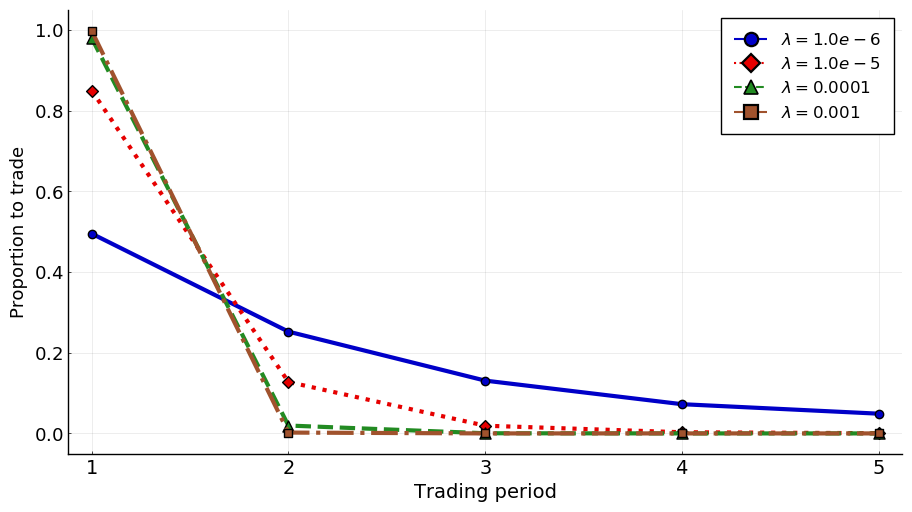

In [15]:
# gets the simulation parameters for the mean-variance framework
theSimulationParameters_Mean_Variance = get_new_simulation_parameters(
    theSimulationParameters,
    aMethod = theMeanVarianceModel
    )

# uncertainty structure when only the price moves are considered
theTraderUncertaintyStructureOnlyPriceMoves = UncertaintyStructureModule.get_new_uncertainty_structure(
    theUncertaintyStructureGroundTruth,
    aConsiderForecastUpdates = false
    )

# market details structure belief of a trader considering only the price moves are considered
theTraderMarketDetailsBeliefOnlyPriceMoves = MarketDetailsModule.get_new_market_details(
    theMarketDetailsGroundTruth,
    aTradersUncertaintyStructure = [theTraderUncertaintyStructureOnlyPriceMoves]
    )

# gets the trader considering only price uncertainty
theTrader_PU = get_new_trader(
    theTrader,
    aMarketDetailsBelief = theTraderMarketDetailsBeliefOnlyPriceMoves
)

# computes the optimal strategies
theFigurePath_MeanVariance_PU,
theTraders_MeanVariance_PU,
theOutputFiles_MeanVariance_PU,
theLegend_MeanVariance_PU,
theOptimalTradingPlans_MeanVariance_PU = compute_and_plot_optimal_strategies(
    aRiskAversions                = theMeanVarianceRiskAversions,
    aTrader                       = theTrader_PU,
    aInitialStrategy              = theInitialStrategy,
    aSimulationParameters         = theSimulationParameters_Mean_Variance,
    aFolderToSavePlot             = theFolderImages,
    aControlYAxis                 = true
    );

if theKeepOnlyNotebookOutputs
    IJulia.clear_output()
end;

## Mean-CVaR Framework

The Mean-CVaR framework is the one introduced in the paper [Optimal execution strategy with an uncertain volume target (Vaes and Hauser, 2018)](https://arxiv.org/abs/1810.11454)

### Mean-CVaR framework under price uncertainty, _i.e._ Mean-CVaR (PU)

The next code returns the trading strategies given by the mean-CVaR framework when the trader assumes that there is no uncertainty related to the volume target and thus considers it fixed.

In [16]:
# gets the simulation parameters for the mean-cvar framework
theSimulationParameters_Mean_CVaR = get_new_simulation_parameters(
    theSimulationParameters,
    aMethod = theMeanCVaRModel
    )

# uncertainty structure when only the price moves are considered
theTraderUncertaintyStructureOnlyPriceMoves = UncertaintyStructureModule.get_new_uncertainty_structure(
    theUncertaintyStructureGroundTruth,
    aConsiderForecastUpdates = false
    )

# market details structure belief of a trader considering only the price moves are considered
theTraderMarketDetailsBeliefOnlyPriceMoves = MarketDetailsModule.get_new_market_details(
    theMarketDetailsGroundTruth,
    aTradersUncertaintyStructure = [theTraderUncertaintyStructureOnlyPriceMoves]
    )

# gets the risk-neutral trader considering only price uncertainty
theTrader_PU = get_new_trader(
    theTrader,
    aMarketDetailsBelief = theTraderMarketDetailsBeliefOnlyPriceMoves
);

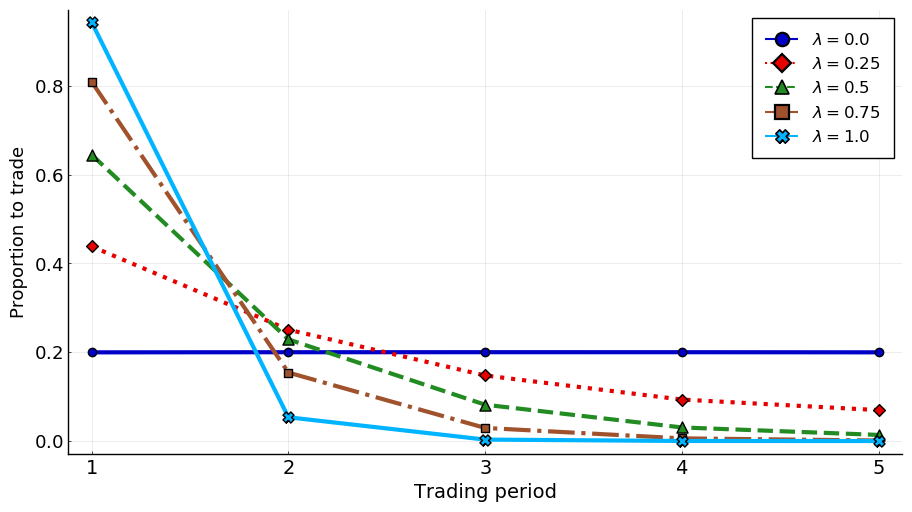

outputs/trading_plan/mean-CVaR/Mean-CVaR_Optim_1583879036694896294.jld2
outputs/trading_plan/mean-CVaR/Mean-CVaR_Optim_16298744333935646438.jld2
outputs/trading_plan/mean-CVaR/Mean-CVaR_Optim_13254185542282087805.jld2
outputs/trading_plan/mean-CVaR/Mean-CVaR_Optim_18094883801617446404.jld2
outputs/trading_plan/mean-CVaR/Mean-CVaR_Optim_17283918110217483676.jld2


In [17]:
# computes the optimal strategies
theFigurePath_MeanCVaR_PU,
theTraders_MeanCVaR_PU,
theOutputFiles_MeanCVaR_PU,
theLegend_MeanCVaR_PU,
theOptimalTradingPlans_MeanCVaR_PU = compute_and_plot_optimal_strategies(
    aRiskAversions                = theMeanCVaRRiskAversions,
    aTrader                       = theTrader_PU,
    aInitialStrategy              = theInitialStrategy,
    aSimulationParameters         = theSimulationParameters_Mean_CVaR,
    aFolderToSavePlot             = theFolderImages,
    aControlYAxis                 = false,
    aYlimits                      = [-0.05,1.0],
    aYticks                       = [0,0.1,1],
    );

if theKeepOnlyNotebookOutputs
    IJulia.clear_output()
end;

[println(theOutputFiles_MeanCVaR_PU[i]) for i in eachindex(theOutputFiles_MeanCVaR_PU)];

### Mean-CVaR framework under volume uncertainty, _i.e._ Mean-CVaR (VU)

The next code returns the trading strategies given by the mean-CVaR framework when the trader assumes that there is no uncertainty related to the price dynamics and **only considers the uncertainty related to the volume target**.

In [18]:
# # gets the simulation parameters for the mean-cvar framework
# theSimulationParameters_Mean_CVaR = get_new_simulation_parameters(
#     theSimulationParameters,
#     aMethod = theMeanCVaRModel
#     )

# # uncertainty structure when only the forecast updates are considered
# theTraderUncertaintyStructureOnlyForecastUpdates = UncertaintyStructureModule.get_new_uncertainty_structure(
#     theUncertaintyStructureGroundTruth,
#     aConsiderPriceMoves = false
#     )

# # market details structure belief of a trader considering only the price moves are considered
# theTraderMarketDetailsBeliefOnlyForecastUpdates = MarketDetailsModule.get_new_market_details(
#     theMarketDetailsGroundTruth,
#     aTradersUncertaintyStructure = [theTraderUncertaintyStructureOnlyForecastUpdates]
#     )

# # gets the trader considering only volume uncertainty
# theTrader_VU = get_new_trader(
#     theTrader,
#     aMarketDetailsBelief = theTraderMarketDetailsBeliefOnlyForecastUpdates
# );

In [19]:
# # computes the optimal strategies
# theFigurePath_MeanCVaR_VU,
# theTraders_MeanCVaR_VU,
# theOutputFiles_MeanCVaR_VU,
# theLegend_MeanCVaR_VU,
# theOptimalTradingPlans_MeanCVaR_VU = compute_and_plot_optimal_strategies(
#     aRiskAversions                = theMeanCVaRRiskAversions,
#     aTrader                       = theTrader_VU,
#     aInitialStrategy              = theInitialStrategy,
#     aSimulationParameters         = theSimulationParameters_Mean_CVaR,
#     aControlYAxis                 = false,
#     aYlimits                      = [0.0,0.4],
#     aYticks                       = [0,0.05,1],
#     aFolderToSavePlot             = theFolderImages
#     );

# if theKeepOnlyNotebookOutputs
#     IJulia.clear_output()
# end;

### Mean-CVaR framework under price and volume uncertainty, _i.e._ Mean-CVaR (PVU)

The next code returns the trading strategies given by the mean-CVaR framework when the trader assumes **both sources of uncertainty**, _i.e._ the uncertainty related to the price dynamics and the uncertainty related to the volume target.

In [20]:
# gets the simulation parameters for the mean-cvar framework
theSimulationParameters_Mean_CVaR = get_new_simulation_parameters(
    theSimulationParameters,
    aMethod = theMeanCVaRModel
    )

# uncertainty structure when price moves and forecast updates are considered
theTraderUncertaintyStructureBothUncertainties = UncertaintyStructureModule.get_new_uncertainty_structure(
    theUncertaintyStructureGroundTruth
    )

# market details structure belief of a trader considering only the price moves are considered
theTraderMarketDetailsBeliefBothUncertainties = MarketDetailsModule.get_new_market_details(
    theMarketDetailsGroundTruth,
    aTradersUncertaintyStructure = [theTraderUncertaintyStructureBothUncertainties]
    )

# gets the trader considering price and volume uncertainty
theTrader_PVU = get_new_trader(
    theTrader,
    aMarketDetailsBelief = theTraderMarketDetailsBeliefBothUncertainties
);

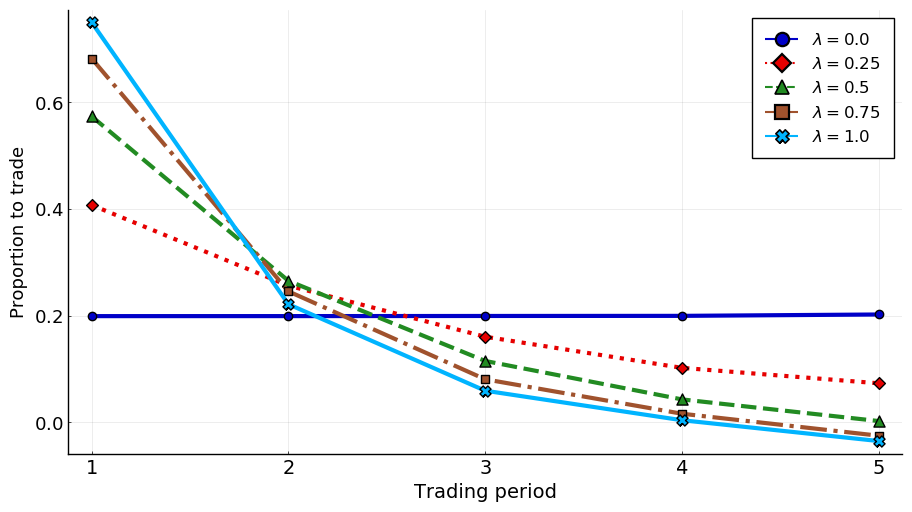

outputs/trading_plan/mean-CVaR/Mean-CVaR_Optim_9643409283823630992.jld2
outputs/trading_plan/mean-CVaR/Mean-CVaR_Optim_6159066767684473640.jld2
outputs/trading_plan/mean-CVaR/Mean-CVaR_Optim_1953755387873539286.jld2
outputs/trading_plan/mean-CVaR/Mean-CVaR_Optim_598671587132145719.jld2
outputs/trading_plan/mean-CVaR/Mean-CVaR_Optim_12748258266810431313.jld2


In [21]:
# computes the optimal strategies
theFigurePath_MeanCVaR_PVU,
theTraders_MeanCVaR_PVU,
theOutputFiles_MeanCVaR_PVU,
theLegend_MeanCVaR_PVU,
theOptimalTradingPlans_MeanCVaR_PVU = compute_and_plot_optimal_strategies(
    aRiskAversions                = theMeanCVaRRiskAversions,
    aTrader                       = theTrader_PVU,
    aInitialStrategy              = theInitialStrategy,
    aSimulationParameters         = theSimulationParameters_Mean_CVaR,
    aFolderToSavePlot             = theFolderImages,
    aControlYAxis                 = false,
    aYlimits                      = [-0.05,1.0],
    aYticks                       = [0,0.1,1]
    );

if theKeepOnlyNotebookOutputs
    IJulia.clear_output()
end;

[println(theOutputFiles_MeanCVaR_PVU[i]) for i in eachindex(theOutputFiles_MeanCVaR_PVU)];

### Volume Uncertainty Impact
This plot represents how the strategies in the Mean-CVaR (PU) framework are changed when considering additionaly the uncertainty related to the volume target, and thus in order to obtain the strategies Mean-CVaR (PVU).

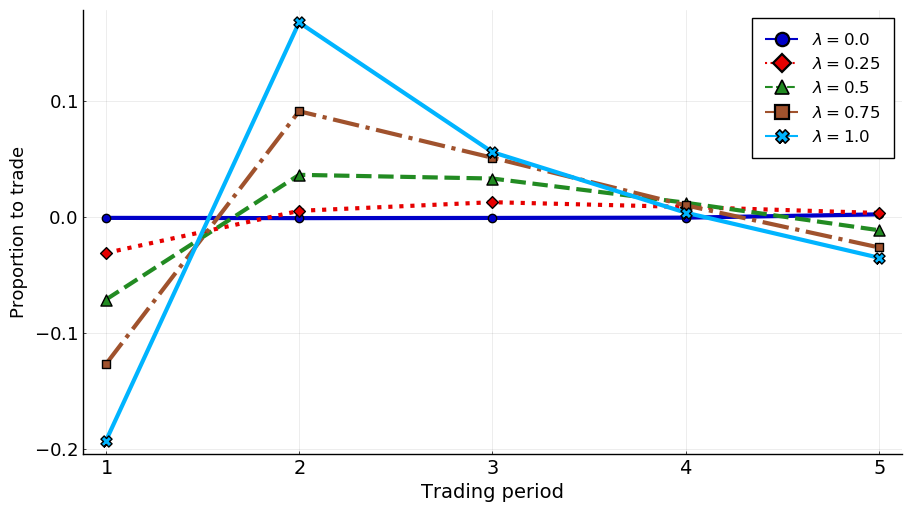

File output with the plot: Difference_alpha_0-1_2173881864962187339.eps


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [22]:
theFolder = theFolderImages

# impact on the optimal strategy when the trader considered the forecast updates
PlotOptimalStrategyModule.generate_difference_optimal_strategies_plot(
    theOutputFiles_MeanCVaR_PU,
    theOutputFiles_MeanCVaR_PVU,
    aAlpha        = theAlpha,
    aLegendVec    = theLegend_MeanCVaR_PVU,
    aImageFolder  = theFolder,
    aControlYAxis = false,
    aYlimits      = [-0.2,0.2],
    aYticks       = [-0.3,0.02,0.35]
    );

# saves the difference in a csv file
save_difference_csv_file!(
    aSimulationParameters = theSimulationParameters_Mean_CVaR,
    aTrader = theTrader,
    aRiskAversions = theMeanCVaRRiskAversions,
    aOutputFilesTradingPlan1 = theOutputFiles_MeanCVaR_PU,
    aOutputFilesTradingPlan2 = theOutputFiles_MeanCVaR_PVU
    )

# IJulia.clear_output();

# Performance tables
Given the ground truth market details, the perfomance of the different methods is computed.
The values that we analyse are the expectation, the variance and the CVaR.

**Note**: The function `show_table_performances` returns a table compilable in latex.
Find more details in the file `script_functions.jl` where it is implemented.

In [23]:
##########################
### Performance tables ###
##########################

# the number of realisations to generate in order to compute the statistical values (Mean, CVaR, Variance) of the trading cost of a strategy in the mean-variance framework with recourse (Almgren and Chriss)
theNSamplesPerformanceMeanVarianceRec = 10^7;

# the number of realisations to generate in order to compute the statistical values (Mean, CVaR, Variance) of the trading cost of a strategy in the mean-CVaR framework
theNSamplesPerformanceMeanCVaR = 10^7;

# the values for α of CVaR_α for which one desires to compute the values and report them in the tables
theAlphaLevelsToCompute = [theAlpha,0.3,0.1,0.05,0.025,0.01,0.005];

# a list of the quantities one can ask to put in the tables
theListNamesQuantities = ["Expectation","Variance","CVaR_0.3","CVaR_0.1","CVaR_0.05",string("CVaR_",theAlpha),string("Mean-CVaR_",theAlpha)];



In [24]:
# uncertainty structure containing the ground truth distributions of the underlying random variables (which is not necessarily known by the trader)
theMarketDetailsResultsUncertaintyStructure_W_VU = UncertaintyStructureModule.get_uncertainty_structure(
    aNTradingPeriods              = theNTradingPeriods,
    aConsiderPriceMoves           = true,
    aInitialPrice                 = theS0, # TODO
    aPricesMovesDistributions     = thePricesDistributions,
    aConsiderForecastUpdates      = true,
    aInitialDemandForecast        = theD0,
    aForecastUpdatesDistributions = theForecastsUpdatesDistributions
    )

# market details structure
theMarketDetailsResults_W_VU = MarketDetailsModule.get_market_details(
    aNTradingPeriods       = theNTradingPeriods,
    aNTraders              = 1,
    aTaus                  = theTaus,
    aGammas                = theGammas,
    aEpsilons              = theEpsilons,
    aEtas                  = theEtas,
    aCostEstimateMethod    = theCostEstimateMethod,
    aTradersUncertaintyStructure  = [theMarketDetailsResultsUncertaintyStructure_W_VU],
    );

## Recursive Mean-Variance

This strategy consists of solving the Mean-Variance framework of the paper [Optimal execution of portfolio transactions (Almgren and Chriss, 2001)](https://doi.org/10.21314/JOR.2001.041) whenever a new demand update is available. _Confer_ our paper [Optimal execution strategy with an uncertain volume target [Vaes & Hauser (2018)]](https://arxiv.org/abs/1810.11454) for more details.

In [25]:
# returns a performance table when only price uncertainty is considered in the Recursive Mean-Variance framework

theListNamesQuantities = ["Expectation","CVaR_0.1","CVaR_0.05","CVaR_0.01","Variance"]

thePerformancesMeanVarianceRecursive_W_VU = []
thePerformancesMeanVarianceRecursiveFilePathes_W_VU = []

theSimulationParameters_MeanVariance_PU_with_recourse = get_new_simulation_parameters(
    theSimulationParameters_Mean_Variance,
    aConsiderRecourse = true
    )

for myTraderNumericalResults in theTraders_MeanVariance_PU
    thePerformanceDict, theOutputPerformanceFilePath = get_optimal_trading_plan_performance(
        aMarketDetailsForRealisations         = theMarketDetailsResults_W_VU,
        aTraderIndex                          = 1,
        aTraders                              = [myTraderNumericalResults],
        aStrategies                           = [get_strategy(aNTradingPeriods = theNTradingPeriods)],
        aSimulationParameters                 = theSimulationParameters_MeanVariance_PU_with_recourse,
        aNTradingCostRealisations             = theNSamplesPerformanceMeanVarianceRec,
        aAlphaLevelsToCompute                 = theAlphaLevelsToCompute
    )
    push!(thePerformancesMeanVarianceRecursive_W_VU,thePerformanceDict)
    push!(thePerformancesMeanVarianceRecursiveFilePathes_W_VU,theOutputPerformanceFilePath)
end

# BEGIN: adds the row corresponding to the strategy when the risk aversion tends to +∞

theExclusivelyRiskFocusedTrader = get_new_trader(theTraders_MeanVariance_PU[1], aRiskAversion = Inf)

theExclusivelyRiskFocusedTradingPlan    = zeros(theNTradingPeriods)
theExclusivelyRiskFocusedTradingPlan[1] = 1.0

theExclusivelyRiskFocusedRedMatrix = zeros(theNTradingPeriods,theNTradingPeriods)
[theExclusivelyRiskFocusedRedMatrix[k,k+1] = 1.0 for k = 1:theNTradingPeriods-1]

theExclusivelyRiskFocusedStrategy = get_strategy(
    aNTradingPeriods      = theNTradingPeriods,
    aTradingPlan          = theExclusivelyRiskFocusedTradingPlan,
    aRedistributionMatrix = theExclusivelyRiskFocusedRedMatrix
    )

thePerformanceDict, theOutputPerformanceFilePath = get_optimal_trading_plan_performance(
    aMarketDetailsForRealisations         = theMarketDetailsResults_W_VU,
    aTraderIndex                          = 1,
    aTraders                              = [theExclusivelyRiskFocusedTrader],
    aStrategies                           = [theExclusivelyRiskFocusedStrategy],
    aSimulationParameters                 = theSimulationParameters_Mean_CVaR,
    aNTradingCostRealisations             = theNSamplesPerformanceMeanCVaR,
    aAlphaLevelsToCompute                 = theAlphaLevelsToCompute
)

push!(thePerformancesMeanVarianceRecursive_W_VU,thePerformanceDict)
push!(thePerformancesMeanVarianceRecursiveFilePathes_W_VU,theOutputPerformanceFilePath)

# END: adds the row corresponding to the strategy when the risk aversion tends to +∞

theMarkdownTableMeanVarianceRecursive = show_table_performances(
    aArrayPerformances   = thePerformancesMeanVarianceRecursive_W_VU,
    aAlpha               = theAlpha,
    aListNamesQuantities = theListNamesQuantities
)

if theKeepOnlyNotebookOutputs
    IJulia.clear_output()
end

if theGenerateLatexTables
    show(stdout, MIME"text/latex"(), theMarkdownTableMeanVarianceRecursive)
end

theMarkdownTableMeanVarianceRecursive

| Risk-aversion | Expectation | CVaR$_{0.1}$ | CVaR$_{0.05}$ | CVaR$_{0.01}$ | Variance |
|:------------- |:-----------:|:------------:|:-------------:|:-------------:|:--------:|
| 1.0e-6        |  362400.0   |   1.016e6    |    1.182e6    |    1.554e6    | 1.076e11 |
| 1.0e-5        |  561500.0   |   933400.0   |    1.042e6    |    1.301e6    | 3.333e10 |
| 0.0001        |  671600.0   |   993400.0   |    1.089e6    |    1.32e6     | 2.721e10 |
| 0.001         |  689100.0   |   1.007e6    |    1.101e6    |    1.327e6    |  2.7e10  |
| Inf           |  691300.0   |   1.009e6    |    1.102e6    |    1.328e6    | 2.698e10 |


## Mean-CVaR

This strategy is the one presented in our paper, _confer_ [Optimal execution strategy with an uncertain volume target [Vaes & Hauser (2018)]](https://arxiv.org/abs/1810.11454) for more details.

### Mean-CVaR (PU)

In [26]:
## Mean-CVaR ##

### Mean-CVaR (PU) ###

# returns a performance table when only price uncertainty is considered in the Mean-CVaR model
thePerformancesMeanCVaRPU_W_VU = []
thePerformancesMeanCVaRPU_W_VUFilePathes_W_VU = []
theListNamesQuantities   = ["Expectation","CVaR_0.1","CVaR_0.05","CVaR_0.01","Variance",string("Mean-CVaR_",theAlpha)];

for i in eachindex(theTraders_MeanCVaR_PU)
    
    myTraderNumericalResults = theTraders_MeanCVaR_PU[i]
    theOutputFile_MeanCVaR_PU = theOutputFiles_MeanCVaR_PU[i]
    myOptimalStrategy = HelpFilesModule.load_strategy_from_file(theOutputFile_MeanCVaR_PU)
    
    thePerformanceDict, theOutputPerformanceFilePath = get_optimal_trading_plan_performance(
        aMarketDetailsForRealisations         = theMarketDetailsResults_W_VU,
        aTraderIndex                          = 1,
        aTraders                              = [myTraderNumericalResults],
        aStrategies                           = [myOptimalStrategy],
        aSimulationParameters                 = theSimulationParameters_Mean_CVaR,
        aNTradingCostRealisations             = theNSamplesPerformanceMeanCVaR,
        aAlphaLevelsToCompute                 = theAlphaLevelsToCompute
    )
    
    push!(thePerformancesMeanCVaRPU_W_VU,thePerformanceDict)
    push!(thePerformancesMeanCVaRPU_W_VUFilePathes_W_VU,theOutputPerformanceFilePath)
    
end 
theMarkdownTableMeanCVaRPU = show_table_performances(
    aArrayPerformances   = thePerformancesMeanCVaRPU_W_VU,
    aAlpha               = theAlpha,
    aListNamesQuantities = theListNamesQuantities
)

if theKeepOnlyNotebookOutputs
    IJulia.clear_output()
end

if theGenerateLatexTables
    show(stdout, MIME"text/latex"(), theMarkdownTableMeanCVaRPU)
end

theMarkdownTableMeanCVaRPU


| Risk-aversion | Expectation | CVaR$_{0.1}$ | CVaR$_{0.05}$ | CVaR$_{0.01}$ | Variance | Mean-CVaR$_{0.1}$ |
|:------------- |:-----------:|:------------:|:-------------:|:-------------:|:--------:|:-----------------:|
| 0.0           |  297300.0   |   1.352e6    |    1.587e6    |    2.093e6    | 3.087e11 |     297300.0      |
| 0.25          |  341300.0   |   1.063e6    |    1.242e6    |    1.641e6    | 1.334e11 |     521600.0      |
| 0.5           |  430200.0   |   945200.0   |    1.089e6    |    1.422e6    | 6.406e10 |     687700.0      |
| 0.75          |  526700.0   |   931800.0   |    1.055e6    |    1.349e6    | 3.924e10 |     830500.0      |
| 1.0           |  627400.0   |   983100.0   |    1.096e6    |    1.368e6    | 3.141e10 |     983100.0      |


### Mean-CVaR (PVU)

In [27]:
### Mean-CVaR (PVU) ###

# returns a performance table when price and volume uncertainty are considered in the Mean-CVaR model
thePerformancesMeanCVaRPVU_W_VU = []
thePerformancesMeanCVaRPVU_W_VUFilePathes_W_VU = []
for i in eachindex(theTraders_MeanCVaR_PVU)
    
    myTraderNumericalResults = theTraders_MeanCVaR_PVU[i]
    theOutputFile_MeanCVaR_PVU = theOutputFiles_MeanCVaR_PVU[i]
    myOptimalStrategy = HelpFilesModule.load_strategy_from_file(theOutputFile_MeanCVaR_PVU)

    thePerformanceDict, theOutputPerformanceFilePath = get_optimal_trading_plan_performance(
        aMarketDetailsForRealisations         = theMarketDetailsResults_W_VU,
        aTraderIndex                          = 1,
        aTraders                              = [myTraderNumericalResults],
        aStrategies                           = [myOptimalStrategy],
        aSimulationParameters                 = theSimulationParameters_Mean_CVaR,
        aNTradingCostRealisations             = theNSamplesPerformanceMeanCVaR,
        aAlphaLevelsToCompute                 = theAlphaLevelsToCompute
    )
    
    push!(thePerformancesMeanCVaRPVU_W_VU,thePerformanceDict)
    push!(thePerformancesMeanCVaRPVU_W_VUFilePathes_W_VU,theOutputPerformanceFilePath)
    
end

theMarkdownTableMeanCVaRPVU = show_table_performances(
    aArrayPerformances   = thePerformancesMeanCVaRPVU_W_VU,
    aAlpha               = theAlpha,
    aListNamesQuantities = theListNamesQuantities
)

if theKeepOnlyNotebookOutputs
    IJulia.clear_output()
end

if theGenerateLatexTables
    show(stdout, MIME"text/latex"(), theMarkdownTableMeanCVaRPVU)
end

theMarkdownTableMeanCVaRPVU

| Risk-aversion | Expectation | CVaR$_{0.1}$ | CVaR$_{0.05}$ | CVaR$_{0.01}$ | Variance | Mean-CVaR$_{0.1}$ |
|:------------- |:-----------:|:------------:|:-------------:|:-------------:|:--------:|:-----------------:|
| 0.0           |  297300.0   |   1.354e6    |    1.59e6     |    2.098e6    |  3.1e11  |     297300.0      |
| 0.25          |  333100.0   |   1.084e6    |    1.269e6    |    1.677e6    | 1.465e11 |     520900.0      |
| 0.5           |  401700.0   |   964100.0   |    1.114e6    |    1.457e6    | 7.876e10 |     682900.0      |
| 0.75          |  458600.0   |   927400.0   |    1.058e6    |    1.366e6    | 5.476e10 |     810200.0      |
| 1.0           |  498300.0   |   921300.0   |    1.042e6    |    1.331e6    | 4.504e10 |     921300.0      |


## Summary of the performance tables

In [28]:
println("\n\nMean-Variance (Recursive)\n")
show(theMarkdownTableMeanVarianceRecursive)
println("\n\nMean-CVar (PU)\n")
show(theMarkdownTableMeanCVaRPU)
println("\n\nMean-CVar (PVU)\n")
show(theMarkdownTableMeanCVaRPVU)



Mean-Variance (Recursive)

| Risk-aversion | Expectation | CVaR$_{0.1}$ | CVaR$_{0.05}$ | CVaR$_{0.01}$ | Variance |
|:------------- |:-----------:|:------------:|:-------------:|:-------------:|:--------:|
| 1.0e-6        |  362400.0   |   1.016e6    |    1.182e6    |    1.554e6    | 1.076e11 |
| 1.0e-5        |  561500.0   |   933400.0   |    1.042e6    |    1.301e6    | 3.333e10 |
| 0.0001        |  671600.0   |   993400.0   |    1.089e6    |    1.32e6     | 2.721e10 |
| 0.001         |  689100.0   |   1.007e6    |    1.101e6    |    1.327e6    |  2.7e10  |
| Inf           |  691300.0   |   1.009e6    |    1.102e6    |    1.328e6    | 2.698e10 |


Mean-CVar (PU)

| Risk-aversion | Expectation | CVaR$_{0.1}$ | CVaR$_{0.05}$ | CVaR$_{0.01}$ | Variance | Mean-CVaR$_{0.1}$ |
|:------------- |:-----------:|:------------:|:-------------:|:-------------:|:--------:|:-----------------:|
| 0.0           |  297300.0   |   1.352e6    |    1.587e6    |    2.093e6    | 3.087e11 |     297300.0 

# Comparison PDFs and CDFs
## Trading cost realisations

Gets the trading cost realisations of the strategies of the different models.

### Recursive Mean-Variance

In [29]:
############################
# Comparison PDFs and CDFs #
############################

# gets the trading cost when only price uncertainty is considered in the recursive Mean-Variance framework
theMethod = "MeanVariance"

theDensities_MeanVariance_PU_with_recourse_W_VU = DataFrame()
theMeanVarianceNames_W_VU = []

for myTraderNumericalResults in theTraders_MeanVariance_PU

    myColumnName = Symbol(string(theMethod,TradingCostModule.get_risk_aversion(myTraderNumericalResults)))
    
    theRealisations = get_optimal_plan_trading_cost_realisations(
        aMarketDetailsForRealisations         = theMarketDetailsResults_W_VU,
        aTraderIndex                          = 1,
        aTraders                              = [myTraderNumericalResults],
        aStrategies                           = [get_strategy(aNTradingPeriods = theNTradingPeriods)],
        aSimulationParameters                 = theSimulationParameters_MeanVariance_PU_with_recourse,
        aNTradingCostRealisations             = theNSamplesPerformanceMeanVarianceRec,
        )

    theDensities_MeanVariance_PU_with_recourse_W_VU[!, myColumnName] = theRealisations
    push!(theMeanVarianceNames_W_VU,myColumnName)
    
end

# BEGIN: adds the strategy when the risk aversion tends to +∞

myColumnName = Symbol(string(theMethod,TradingCostModule.get_risk_aversion(theExclusivelyRiskFocusedTrader)))
theRealisations = get_optimal_plan_trading_cost_realisations(
    aMarketDetailsForRealisations         = theMarketDetailsResults_W_VU,
    aTraderIndex                          = 1,
    aTraders                              = [theExclusivelyRiskFocusedTrader],
    aStrategies                           = [theExclusivelyRiskFocusedStrategy],
    aSimulationParameters                 = theSimulationParameters_Mean_CVaR,
    aNTradingCostRealisations             = theNSamplesPerformanceMeanVarianceRec,
    )

theDensities_MeanVariance_PU_with_recourse_W_VU[!, myColumnName] = theRealisations
push!(theMeanVarianceNames_W_VU,myColumnName);

# END: adds the strategy when the risk aversion tends to +∞


┌ Info: 
│ PerformanceModule 101:
│ Some realisations have already been computed and will be imported. There are consequently a number of 0 left to compute out of the initial 10000000.
│ If you want to force the recomputation of all realisations then put the parameter `aRecomputePerformances=true` in the SimulationParameters structure `aSimulationParameters`.Otherwise, you can also delete the file:
│ outputs/trading_cost_realisations/Mean-Variance/Mean-Variance_12587192823198225731_recursive_realisations.jld2.
└ @ Main.HelpFilesModule /Users/jvaes/Documents/local-research/implementation_trading_uncertain_volume/src/help_files.jl:390
┌ Info: 
│ PerformanceModule 101:
│ Some realisations have already been computed and will be imported. There are consequently a number of 0 left to compute out of the initial 10000000.
│ If you want to force the recomputation of all realisations then put the parameter `aRecomputePerformances=true` in the SimulationParameters structure `aSimulationParameters

### Mean-CVaR
#### Mean-CVaR (PU)

In [30]:
# gets the trading cost when only price uncertainty is considered in the Mean-CVaR model
theMethod = "MeanCVaRPU"

theDensitiesMeanCVaRPU_W_VU = DataFrame()
theMeanCVaRPUNames_W_VU = []
for p in eachindex(theTraders_MeanCVaR_PU)
    
    myTrader = theTraders_MeanCVaR_PU[p]
    
    myColumnName = Symbol(string(theMethod,TradingCostModule.get_risk_aversion(myTrader)))
    
    theOutputFile = theOutputFiles_MeanCVaR_PU[p]
    
    myOptimalStrategy = load_strategy_from_file(theOutputFile)
    
    theRealisations = get_optimal_plan_trading_cost_realisations(
        aMarketDetailsForRealisations         = theMarketDetailsResults_W_VU,
        aTraderIndex                          = 1,
        aTraders                              = [myTrader],
        aStrategies                           = [myOptimalStrategy],
        aSimulationParameters                 = theSimulationParameters_Mean_CVaR,
        aNTradingCostRealisations             = theNSamplesPerformanceMeanCVaR
        )
    
    theDensitiesMeanCVaRPU_W_VU[!, myColumnName] = theRealisations
    push!(theMeanCVaRPUNames_W_VU,myColumnName)
end


┌ Info: 
│ PerformanceModule 101:
│ Some realisations have already been computed and will be imported. There are consequently a number of 0 left to compute out of the initial 10000000.
│ If you want to force the recomputation of all realisations then put the parameter `aRecomputePerformances=true` in the SimulationParameters structure `aSimulationParameters`.Otherwise, you can also delete the file:
│ outputs/trading_cost_realisations/Mean-CVaR_Optim/Mean-CVaR_Optim_16531435278816697025_realisations.jld2.
└ @ Main.HelpFilesModule /Users/jvaes/Documents/local-research/implementation_trading_uncertain_volume/src/help_files.jl:390
┌ Info: 
│ PerformanceModule 101:
│ Some realisations have already been computed and will be imported. There are consequently a number of 0 left to compute out of the initial 10000000.
│ If you want to force the recomputation of all realisations then put the parameter `aRecomputePerformances=true` in the SimulationParameters structure `aSimulationParameters`.Othe

#### Mean-CVaR (PVU)

In [31]:
# gets the trading cost when price and volume uncertainty are considered in the Mean-CVaR model
theMethod = "MeanCVaRPVU"

theDensitiesMeanCVaRPVU_W_VU = DataFrame()
theMeanCVaRPVUNames     = []
for p in eachindex(theTraders_MeanCVaR_PVU)
    
    myTrader = theTraders_MeanCVaR_PVU[p]
    
    myColumnName = Symbol(string(theMethod,TradingCostModule.get_risk_aversion(myTrader)))
    
    theOutputFile = theOutputFiles_MeanCVaR_PVU[p]

    myOptimalStrategy = load_strategy_from_file(theOutputFile)

    theRealisations = get_optimal_plan_trading_cost_realisations(
        aMarketDetailsForRealisations         = theMarketDetailsResults_W_VU,
        aTraderIndex                          = 1,
        aTraders                              = [myTrader],
        aStrategies                           = [myOptimalStrategy],
        aSimulationParameters                 = theSimulationParameters_Mean_CVaR,
        aNTradingCostRealisations             = theNSamplesPerformanceMeanCVaR
        )

    theDensitiesMeanCVaRPVU_W_VU[!, myColumnName] = theRealisations
    
    push!(theMeanCVaRPVUNames,myColumnName)
end


┌ Info: 
│ PerformanceModule 101:
│ Some realisations have already been computed and will be imported. There are consequently a number of 0 left to compute out of the initial 10000000.
│ If you want to force the recomputation of all realisations then put the parameter `aRecomputePerformances=true` in the SimulationParameters structure `aSimulationParameters`.Otherwise, you can also delete the file:
│ outputs/trading_cost_realisations/Mean-CVaR_Optim/Mean-CVaR_Optim_10278024960328755164_realisations.jld2.
└ @ Main.HelpFilesModule /Users/jvaes/Documents/local-research/implementation_trading_uncertain_volume/src/help_files.jl:390
┌ Info: 
│ PerformanceModule 101:
│ Some realisations have already been computed and will be imported. There are consequently a number of 0 left to compute out of the initial 10000000.
│ If you want to force the recomputation of all realisations then put the parameter `aRecomputePerformances=true` in the SimulationParameters structure `aSimulationParameters`.Othe

## Impact: uncertainty of volume target

We illustrate here the comparision of the PDFs and CDFs of the trading cost for the strategies in the mean-CVaR (PU) and mean-CVaR (PVU) frameworks. This clearly illustrates the benefit of integrating the uncertainty realted to volume target into the model

In [32]:
theMeanCVaRRiskAversionsToPlot = [0.25,0.5,0.75,1.0]

theHashOutputFiles = hash(string(theOutputFiles_MeanCVaR_PU,theOutputFiles_MeanCVaR_PVU))

theRealisations_W_VU = []
for i in eachindex(theMeanCVaRRiskAversions)
    if in(theMeanCVaRRiskAversions[i],theMeanCVaRRiskAversionsToPlot)
        myLocalMeanCVaRPURealisations = Array{Float64,1}(theDensitiesMeanCVaRPU_W_VU[!,theMeanCVaRPUNames_W_VU[i]])
        myLocalMeanCVaRPVURealisations = Array{Float64,1}(theDensitiesMeanCVaRPVU_W_VU[!,theMeanCVaRPVUNames[i]])
        myLocalRealisations = Array{Array{Float64,1},1}([myLocalMeanCVaRPURealisations,myLocalMeanCVaRPVURealisations])
        push!(theRealisations_W_VU,myLocalRealisations)
    end
end


### PDFs comparision

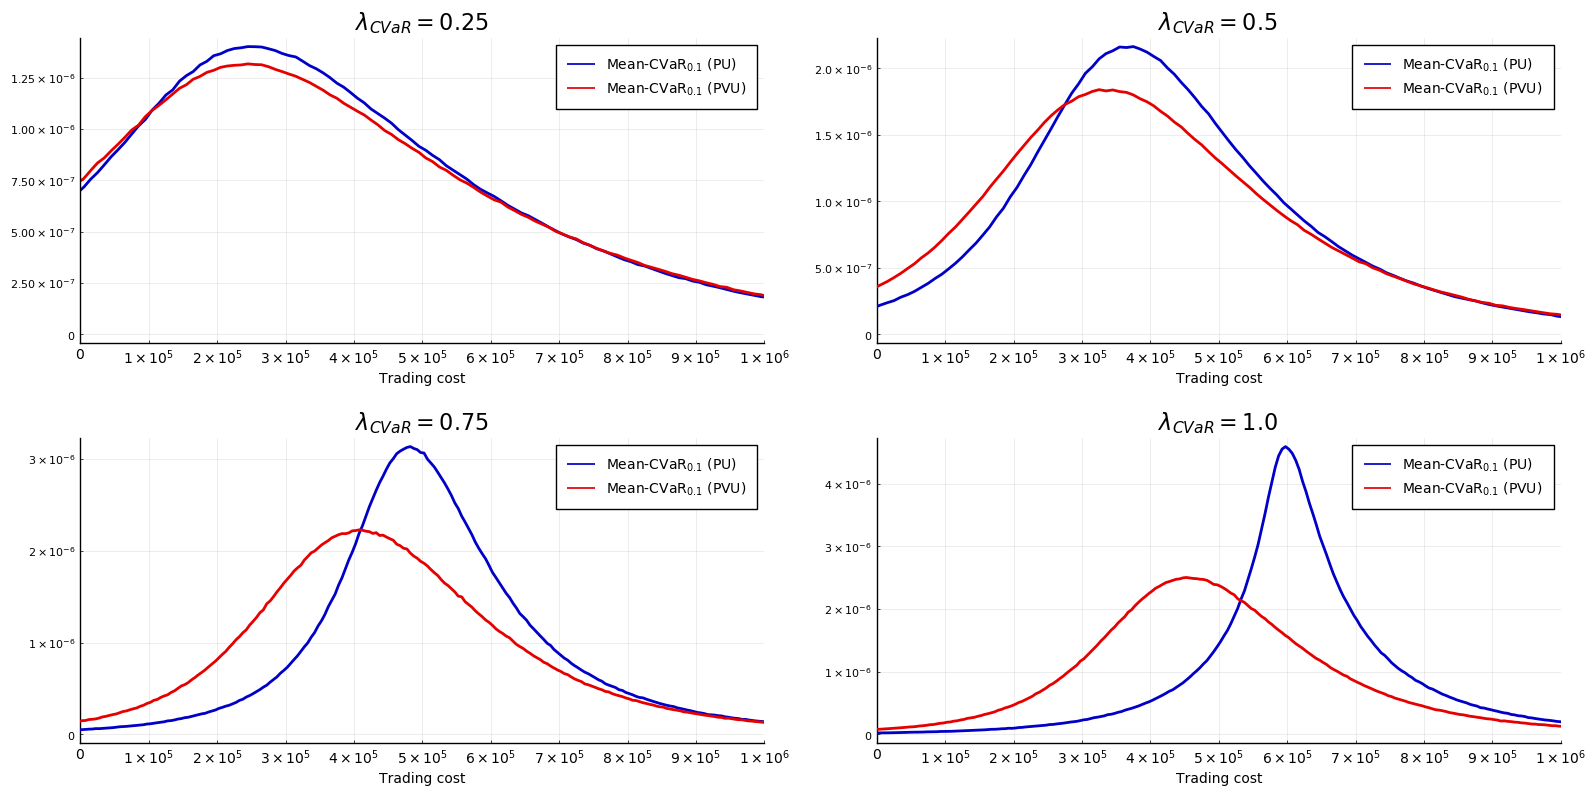

In [33]:
# the name under which to save the plot
thePlotPDFComparisonName = string(theFolderImages,"impact_volume_uncertainty_pdf_n_",theNSamplesPerformanceMeanCVaR,"_",theHashOutputFiles,".eps")
plot_comparison_pdf_methods!(
    aRiskAversions        = theMeanCVaRRiskAversionsToPlot,
    aRealisations         = theRealisations_W_VU,
    aMethodNameLabels     = ["Mean-CVaR\$_{0.1}\$ (PU)", "Mean-CVaR\$_{0.1}\$ (PVU)"],
    aFileNameToSaveFigure = thePlotPDFComparisonName,
    aLegendPosition       = :topright,
    aXLowerLim            = 0.0,   # lower limit of the x-axis
    aXUpperLim            = 1.0*10^6 # upper limit of the x-axis
    )

IJulia.clear_output();


### CDFs comparision

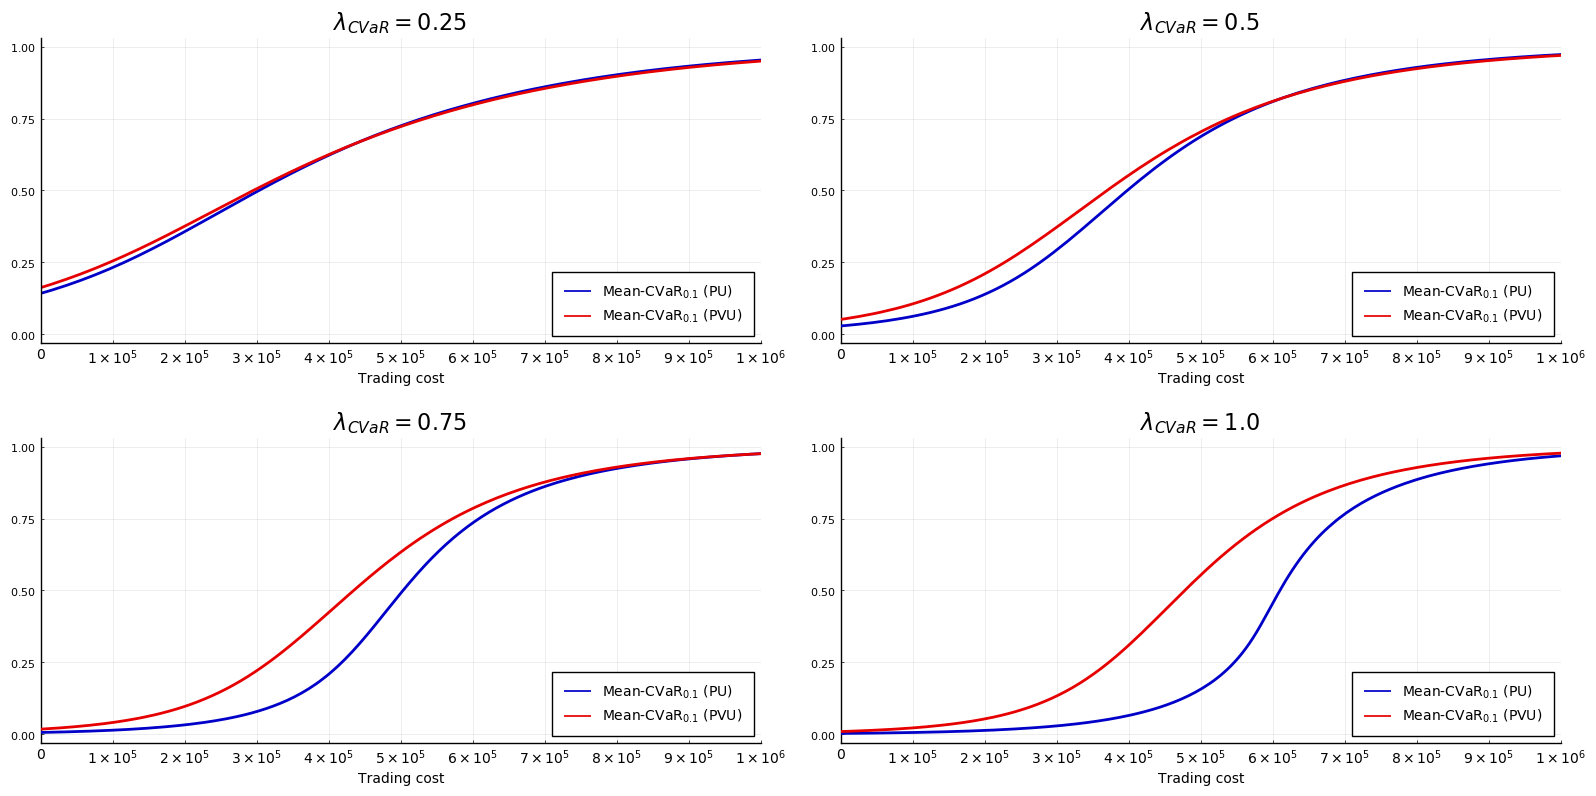

outputs/images/impact_volume_uncertainty_cdf_n_10000000_2173881864962187339.eps


In [34]:
# the name under which to save the plot
thePlotCDFComparisonName = string(theFolderImages,"impact_volume_uncertainty_cdf_n_",theNSamplesPerformanceMeanCVaR,"_",theHashOutputFiles,".eps")

plot_comparison_cdf_methods!(
    aRiskAversions        = theMeanCVaRRiskAversionsToPlot,
    aRealisations         = theRealisations_W_VU,
    aMethodNameLabels     = ["Mean-CVaR\$_{0.1}\$ (PU)", "Mean-CVaR\$_{0.1}\$ (PVU)"],
    aFileNameToSaveFigure = thePlotCDFComparisonName,
    aXLowerLim            = 0.0,   # lower limit of the x-axis
    aXUpperLim            = 1.0*10^6 # upper limit of the x-axis
    )

IJulia.clear_output();

println(thePlotCDFComparisonName)

### Output files

In [35]:
# output files

if theGiveInfoOnOutputFiles
    println("The plot with the comparison of the PDFs is saved under the name:\n",thePlotPDFComparisonName,"\n")
    println("The plot with the comparison of the CDFs is saved under the name:\n",thePlotCDFComparisonName,"\n\n")

    println("The files name entitled pdf_XXXX.txt and cdf_XXXX.tex in the folder\noutputs/txt_files/\nthat contains the details of the pdf and cdf plots.")
    for i in eachindex(theRealisations_W_VU)
        println("\n--------------------------")
        println("- Risk-aversion λ = ",theMeanCVaRRiskAversionsToPlot[i]," -")
        println("--------------------------")
        print("Mean CVaR (PU): ")
        println(string("\n\tpdf_",hash(theRealisations_W_VU[i][1]),".txt\n\t","cdf_",hash(theRealisations_W_VU[i][1]),".txt"))
        print("Mean CVaR (PVU): ")
        println(string("\n\tpdf_",hash(theRealisations_W_VU[i][2]),".txt\n\t","cdf_",hash(theRealisations_W_VU[i][2]),".txt"))
    end
end


The plot with the comparison of the PDFs is saved under the name:
outputs/images/impact_volume_uncertainty_pdf_n_10000000_2173881864962187339.eps

The plot with the comparison of the CDFs is saved under the name:
outputs/images/impact_volume_uncertainty_cdf_n_10000000_2173881864962187339.eps


The files name entitled pdf_XXXX.txt and cdf_XXXX.tex in the folder
outputs/txt_files/
that contains the details of the pdf and cdf plots.

--------------------------
- Risk-aversion λ = 0.25 -
--------------------------
Mean CVaR (PU): 
	pdf_5564720903247356548.txt
	cdf_5564720903247356548.txt
Mean CVaR (PVU): 
	pdf_17453301173654165147.txt
	cdf_17453301173654165147.txt

--------------------------
- Risk-aversion λ = 0.5 -
--------------------------
Mean CVaR (PU): 
	pdf_909425448205330664.txt
	cdf_909425448205330664.txt
Mean CVaR (PVU): 
	pdf_11695357571027349882.txt
	cdf_11695357571027349882.txt

--------------------------
- Risk-aversion λ = 0.75 -
--------------------------
Mean CVaR (PU): 


## Comparision: recursive mean-variance and mean-CVaR (PVU)

We illustrate here the comparision of the PDFs and CDFs of the trading cost for the strategies in the mean-variance with recourse and mean-CVaR (PVU) frameworks.

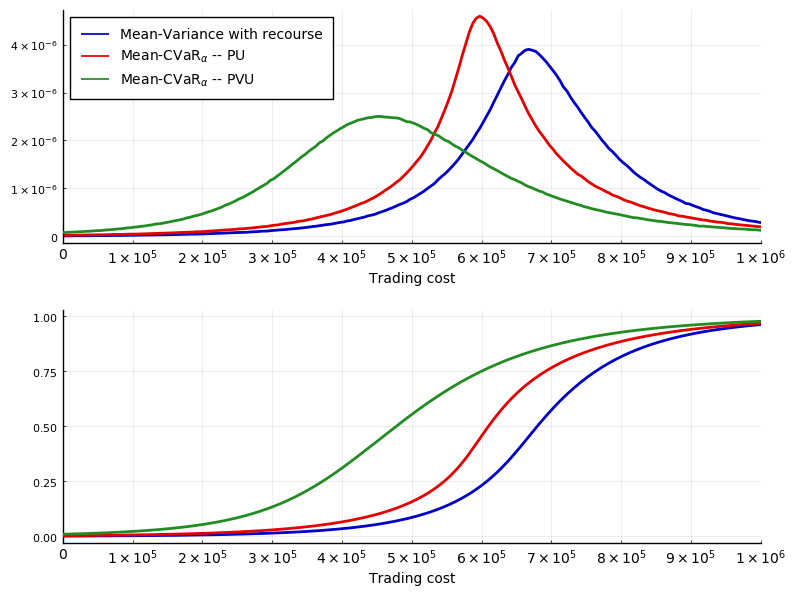

The plot with the comparison of the PDFs and CDFs is saved under the name:
outputs/images/comparison-Mean_Variance_Inf-Mean_CVaR_1-0_n_10000000_10000000_2173881864962187339.eps

The files name entitled pdf_XXXX.txt and cdf_XXXX.tex in the folder
outputs/txt_files/
that contains the details of the pdf and cdf plots.
Mean-variance with recourse: 
	pdf_10412050281790306810.txt
	cdf_10412050281790306810.txt
Mean CVaR (PU): 
	pdf_7377484453574676098.txt
	cdf_7377484453574676098.txt
Mean CVaR (PVU): 
	pdf_9166597946721031336.txt
	cdf_9166597946721031336.txt


In [36]:
# plot: comparision of the PDFs and CDFs of the trading cost obtained with
# (i) the Recusive Mean-Variance model,
# (ii) the Mean-CVaR model when the uncertainty related to the volume target is ignored (PU)
# and (iii) the Mean-CVaR model when the uncertainty related to the volume target is considered (PVU)

theMeanVarianceRiskAversion_Comparison_PDF_CDF = Inf
theMeanCVaRRiskAversion_Comparison_PDF_CDF = 1.0

# gets the realisations for the mean-variance framework corresponding to the risk-aversion given by `theMeanVarianceRiskAversion_Comparison_PDF_CDF`
theMeanVarianceColumnName   = Symbol(string("MeanVariance",theMeanVarianceRiskAversion_Comparison_PDF_CDF))
theMeanVarianceDensity      = theDensities_MeanVariance_PU_with_recourse_W_VU[!,theMeanVarianceColumnName]

# gets the realisations for the mean-CVaR PU framework corresponding to the risk-aversion given by `theMeanCVaRRiskAversion_Comparison_PDF_CDF`
theMeanCVaRColumnName_PU   = Symbol(string("MeanCVaRPU",theMeanCVaRRiskAversion_Comparison_PDF_CDF))
theMeanCVaRDensity_PU      = theDensitiesMeanCVaRPU_W_VU[!,theMeanCVaRColumnName_PU]

# gets the realisations for the mean-CVaR PVU framework corresponding to the risk-aversion given by `theMeanCVaRRiskAversion_Comparison_PDF_CDF`
theMeanCVaRColumnName_PVU   = Symbol(string("MeanCVaRPVU",theMeanCVaRRiskAversion_Comparison_PDF_CDF))
theMeanCVaRDensity_PVU      = theDensitiesMeanCVaRPVU_W_VU[!,theMeanCVaRColumnName_PVU]

# the name under which to save the plot
theMeanVarianceRiskAversionString = replace(string(theMeanVarianceRiskAversion_Comparison_PDF_CDF),"." => "-")
theMeanCVaRRiskAversionString     = replace(string(theMeanCVaRRiskAversion_Comparison_PDF_CDF),"." => "-")
thePlotComparisonMeanVarianceCVaRName = string(theFolderImages,"comparison-Mean_Variance_",theMeanVarianceRiskAversionString,"-Mean_CVaR_",theMeanCVaRRiskAversionString,"_n_",theNSamplesPerformanceMeanCVaR,"_",theNSamplesPerformanceMeanCVaR,"_",theHashOutputFiles,".eps")

plot_comparison_pdf_and_cdf_empircal_distributions!(
    aRealisations        = [theMeanVarianceDensity,theMeanCVaRDensity_PU,theMeanCVaRDensity_PVU],
    aLabels              = ["Mean-Variance with recourse","Mean-CVaR\$_{\\alpha}\$ -- PU","Mean-CVaR\$_{\\alpha}\$ -- PVU"],
    aFileNameToSaveFigure = thePlotComparisonMeanVarianceCVaRName,
    aXLowerLim            = 0.0,   # lower limit of the x-axis
    aXUpperLim            = 1.0*10^6, # upper limit of the x-axis
    aLegendPosition       = :topleft
    );

IJulia.clear_output();

# output files

if theGiveInfoOnOutputFiles
    println("The plot with the comparison of the PDFs and CDFs is saved under the name:\n",thePlotComparisonMeanVarianceCVaRName,"\n")

    println("The files name entitled pdf_XXXX.txt and cdf_XXXX.tex in the folder\noutputs/txt_files/\nthat contains the details of the pdf and cdf plots.")

    print("Mean-variance with recourse: ")
    println(string("\n\tpdf_",hash(theMeanVarianceDensity),".txt\n\t","cdf_",hash(theMeanVarianceDensity),".txt"))
    print("Mean CVaR (PU): ")
    println(string("\n\tpdf_",hash(theMeanCVaRDensity_PU),".txt\n\t","cdf_",hash(theMeanCVaRDensity_PU),".txt"))
    print("Mean CVaR (PVU): ")
    println(string("\n\tpdf_",hash(theMeanCVaRDensity_PVU),".txt\n\t","cdf_",hash(theMeanCVaRDensity_PVU),".txt"))
end


# Analysis of the bid-ask spread profile (or liquidity profile) on the trading strategy

## Market parameters for the analysis of the bid-ask spread profile 

In [37]:
# the ground truth uncertainty structure 
theUncertaintyStructureGroundTruth = theMarketDetailsResultsUncertaintyStructure_W_VU

# risk aversions for which one desires to anaylse the impact of the liquidity profile
theMeanCVaRRiskAversionsLiquidityProfile = [1.0]

# parameter b (bid-ask spread) #

# vector containing the different bid-ask spread profile for which to analyse the impact
theBidAskSpreadProfiles = []
push!(theBidAskSpreadProfiles,[0.0025,  0.0025, 0.0025,  0.0025,  0.0025]*theS0)
push!(theBidAskSpreadProfiles,[0.008,  0.004, 0.002,  0.004,  0.008]*theS0)
push!(theBidAskSpreadProfiles,[0.002,  0.006, 0.008,  0.006,  0.002]*theS0)
push!(theBidAskSpreadProfiles,[0.016,  0.008, 0.004,  0.002,  0.001]*theS0)
push!(theBidAskSpreadProfiles,[0.001,  0.002, 0.004,  0.008,  0.016]*theS0);

println("The bid-ask spread profiles that will be analysed:")
theBidAskSpreadProfiles

The bid-ask spread profiles that will be analysed:


5-element Array{Any,1}:
 [0.125, 0.125, 0.125, 0.125, 0.125]
 [0.4, 0.2, 0.1, 0.2, 0.4]          
 [0.1, 0.3, 0.4, 0.3, 0.1]          
 [0.8, 0.4, 0.2, 0.1, 0.05]         
 [0.05, 0.1, 0.2, 0.4, 0.8]         

## Computation of the trading strategies in the mean-CVaR framework (PU and PVU)

In [38]:
# output files
theOutputFilesImpactLiquidityProfilePU         = []
theOutputFilesImpactLiquidityProfilePVU        = []
theOutputFilesImpactLiquidityProfileDifference = []
theVerifyUniquenessCondition                   = []

for myBidAskSpreadProfile in theBidAskSpreadProfiles
    
    # parameter ϵ (epsilon)
    myEpsilons = myBidAskSpreadProfile ./ 2 # the value of ϵ for each trading period
    
    # parameter η (eta)
    myEtas = myBidAskSpreadProfile / (0.01*theDailyVolume) # the value of η for each trading period
    
    # parameter γ (gammas)
    myCoeffGammas = 5
    myGammas      = myCoeffGammas .* myBidAskSpreadProfile ./ (0.1 * theDailyVolume)
    
    # market details structure
    myMarketDetails = MarketDetailsModule.get_market_details(
        aNTradingPeriods             = theNTradingPeriods,
        aNTraders                    = 1,
        aTaus                        = theTaus,
        aGammas                      = myGammas,
        aEpsilons                    = myEpsilons,
        aEtas                        = myEtas,
        aCostEstimateMethod          = theCostEstimateMethod,
        aTradersUncertaintyStructure = [theUncertaintyStructureGroundTruth]
        )
    
    push!(theVerifyUniquenessCondition,get_satisfy_sufficient_condition_for_uniqueness(myMarketDetails))
    
    ############################
    ## Price uncertainty (PU) ##
    ############################
    
    # uncertainty structure when only the price moves are considered
    myTraderUncertaintyStructureOnlyPriceMoves = UncertaintyStructureModule.get_new_uncertainty_structure(
        theUncertaintyStructureGroundTruth,
        aConsiderForecastUpdates = false
        )

    # market details structure belief of a trader considering only the price moves are considered
    myTraderMarketDetailsBeliefOnlyPriceMoves = MarketDetailsModule.get_new_market_details(
        myMarketDetails,
        aTradersUncertaintyStructure = [myTraderUncertaintyStructureOnlyPriceMoves]
        )
    
    # gets the trader considering price and volume uncertainty
    myTrader_PU = get_new_trader(
        theTrader,
        aMarketDetailsBelief = myTraderMarketDetailsBeliefOnlyPriceMoves
        )
        
    ########################################
    ## Price and volume uncertainty (PVU) ##
    ########################################
    
    # uncertainty structure when price moves and forecast updates are considered
    myTraderUncertaintyStructureBothUncertainties = UncertaintyStructureModule.get_new_uncertainty_structure(
        theUncertaintyStructureGroundTruth
        )
    
    # market details structure belief of a trader considering only the price moves are considered
    myTraderMarketDetailsBeliefBothUncertainties = MarketDetailsModule.get_new_market_details(
        myMarketDetails,
        aTradersUncertaintyStructure = [myTraderUncertaintyStructureBothUncertainties]
        )
    
    # gets the trader considering price and volume uncertainty
    myTrader_PVU = get_new_trader(
        theTrader,
        aMarketDetailsBelief = myTraderMarketDetailsBeliefBothUncertainties
        )
    
    #############################
    # Gets the initial strategy #
    #############################
    
    # redistribution matrix when it is assumed that the forecast update errors are redistributed given the risk-neutral mean-variance trading strategy
    myRiskNeutralRedistributionMatrixCorrespondingToProfile = zeros(theNTradingPeriods,theNTradingPeriods)
    for i = 1:theNTradingPeriods-1
        
        # gets the optimal trading plan when there is only `myNTradingPeriods- i` trading periods
        myLocalOptimalStrategy,
        myLocalOptimalObjectiveValue,
        myLocalOptimisationSuccessful,
        myLocalOutputFilePath = MeanVarianceModule.get_optimal_strategy_mean_variance(
            aTraderIndex          = 1,
            aTraders              = [myTrader_PU],
            aStrategies           = [StrategyModule.get_strategy(aNTradingPeriods=theNTradingPeriods)], # this is not used in the mean-variance framework but must be specified
            aSimulationParameters = get_new_simulation_parameters(theSimulationParameters, aRecomputeOptimalStrategies = true),
            aDecisionTimeToComputeOptimalTradingPlan = i
            )
        myLocalOptimalTradingPlanMeanVariance = get_trading_plan(myLocalOptimalStrategy)
        myRiskNeutralRedistributionMatrixCorrespondingToProfile[i,i+1:end] = myLocalOptimalTradingPlanMeanVariance
        
    end 

    myInitialStrategyCorrespondingToProfile = get_strategy(
        aNTradingPeriods      = theNTradingPeriods,
        aTradingPlan          = theInitialTradingPlan,
        aRedistributionMatrix = myRiskNeutralRedistributionMatrixCorrespondingToProfile
        )
    
    ###################################
    # Computes the optimal strategies #
    ###################################
    
    # computes the trading strategy in the mean-CVaR (PU) framework
    myFigurePath_MeanCVaR_PU,
    myTraders_MeanCVaR_PU,
    myOutputFiles_MeanCVaR_PU,
    myLegend_MeanCVaR_PU,
    myOptimalTradingPlans_MeanCVaR_PU = compute_and_plot_optimal_strategies(
        aRiskAversions                = theMeanCVaRRiskAversionsLiquidityProfile,
        aTrader                       = myTrader_PU,
        aInitialStrategy              = myInitialStrategyCorrespondingToProfile,
        aSimulationParameters         = theSimulationParameters_Mean_CVaR,
        aDrawPlot                     = false
        )
    
    push!(theOutputFilesImpactLiquidityProfilePU,myOutputFiles_MeanCVaR_PU)
    
    # computes the trading strategy in the mean-CVaR (PVU) framework
    myFigurePath_MeanCVaR_PVU,
    myTraders_MeanCVaR_PVU,
    myOutputFiles_MeanCVaR_PVU,
    myLegend_MeanCVaR_PVU,
    myOptimalTradingPlans_MeanCVaR_PVU = compute_and_plot_optimal_strategies(
        aRiskAversions                = theMeanCVaRRiskAversionsLiquidityProfile,
        aTrader                       = myTrader_PVU,
        aInitialStrategy              = myInitialStrategyCorrespondingToProfile,
        aSimulationParameters         = theSimulationParameters_Mean_CVaR,
        aDrawPlot                     = false
        )
    
    push!(theOutputFilesImpactLiquidityProfilePVU,myOutputFiles_MeanCVaR_PVU)
    
end

if theKeepOnlyNotebookOutputs
    IJulia.clear_output()
end;
println("The optimal strategies are unique? ", theVerifyUniquenessCondition)

The optimal strategies are unique? Any[true, true, true, true, true]


In [39]:
# output files
if theGiveInfoOnOutputFiles
    println("The output files with the trading strategy.")
    for i in eachindex(theBidAskSpreadProfiles)
        println("\nBid-ask spread profile: ",theBidAskSpreadProfiles[i])
        println("\tMean-CVaR (PU):  ",theOutputFilesImpactLiquidityProfilePU[i][1])
        println("\tMean-CVaR (PVU): ",theOutputFilesImpactLiquidityProfilePVU[i][1])
    end
end
    

The output files with the trading strategy.

Bid-ask spread profile: [0.125, 0.125, 0.125, 0.125, 0.125]
	Mean-CVaR (PU):  outputs/trading_plan/mean-CVaR/Mean-CVaR_Optim_17283918110217483676.jld2
	Mean-CVaR (PVU): outputs/trading_plan/mean-CVaR/Mean-CVaR_Optim_12748258266810431313.jld2

Bid-ask spread profile: [0.4, 0.2, 0.1, 0.2, 0.4]
	Mean-CVaR (PU):  outputs/trading_plan/mean-CVaR/Mean-CVaR_Optim_16250317843818139859.jld2
	Mean-CVaR (PVU): outputs/trading_plan/mean-CVaR/Mean-CVaR_Optim_16118816061462548417.jld2

Bid-ask spread profile: [0.1, 0.3, 0.4, 0.3, 0.1]
	Mean-CVaR (PU):  outputs/trading_plan/mean-CVaR/Mean-CVaR_Optim_913881699359950358.jld2
	Mean-CVaR (PVU): outputs/trading_plan/mean-CVaR/Mean-CVaR_Optim_18107968542728368251.jld2

Bid-ask spread profile: [0.8, 0.4, 0.2, 0.1, 0.05]
	Mean-CVaR (PU):  outputs/trading_plan/mean-CVaR/Mean-CVaR_Optim_7332466679686563240.jld2
	Mean-CVaR (PVU): outputs/trading_plan/mean-CVaR/Mean-CVaR_Optim_5085184449578249984.jld2

Bid-ask spread p

## Illustration of the impact of the liquidity profile

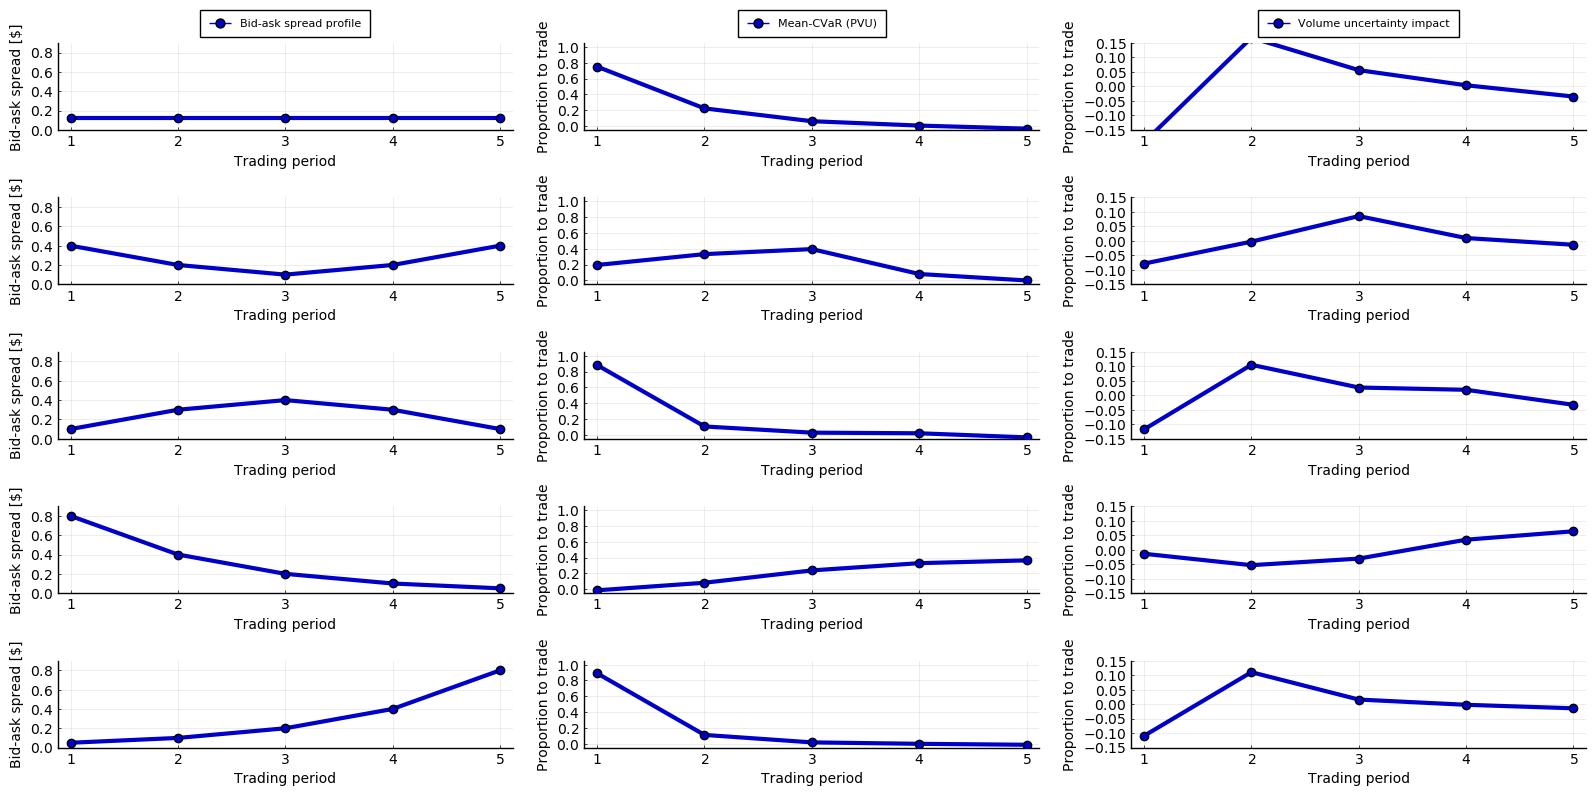

In [40]:
myFigures = plot_analysis_liquidity_profile(
    aRiskAversions         = theMeanCVaRRiskAversionsLiquidityProfile,
    aBidAskSpreadProfiles  = theBidAskSpreadProfiles,
    aOutputFilesPU         = theOutputFilesImpactLiquidityProfilePU,
    aOutputFilesPVU        = theOutputFilesImpactLiquidityProfilePVU,
    aFileNameToSaveFigures = "liquidity_profile_analysis",
    aFolderToSaveFigures   = theFolderImages,
    aControlYAxis          = [true, true,true],
    aYlimits               = [ [0.0,0.9]    , [-0.05,1.05] , [-0.15,0.15] ],
    aYticks                = [ [0.0,0.2,1]  , [0,0.2,1]    , [-0.15,0.05,0.15] ]
    );

if theKeepOnlyNotebookOutputs
    IJulia.clear_output()
end;